In [95]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from einops.layers.torch import Rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt

In [73]:
mean = (0.5)
std = (0.5)
torch.manual_seed(1337)
batch_size = 256
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=224),
    transforms.Normalize(mean, std),

])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=224),
    transforms.Normalize(mean, std),
])

train_set = torchvision.datasets.MNIST(root='./data', train = True, transform=train_transform, download=True)
test_set = torchvision.datasets.MNIST(root='./data', train = False, transform=test_transform)

train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(dataset=test_set, shuffle=True, batch_size=batch_size)

print(f'Test_loader - {len(test_loader.dataset)}')
print(f'Train_loader - {len(train_loader.dataset)}')

Test_loader - 10000
Train_loader - 60000


In [74]:
img, tar = next(iter(train_loader))
img.shape

torch.Size([256, 1, 224, 224])

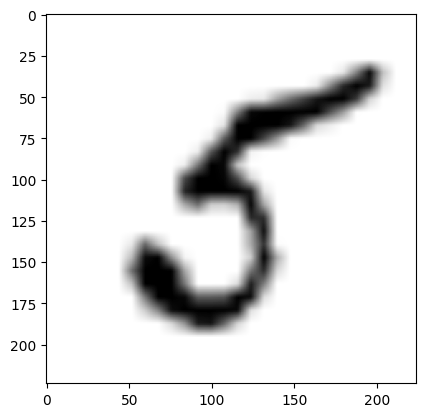

In [75]:
plt.imshow(img[0].permute(1,2,0), cmap = 'binary')
plt.show()

In [76]:
patch_size = 16
a = nn.Sequential(Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', 
                            p1 = patch_size, p2 = patch_size),)
b = a(img).detach()
b.shape

torch.Size([256, 196, 256])

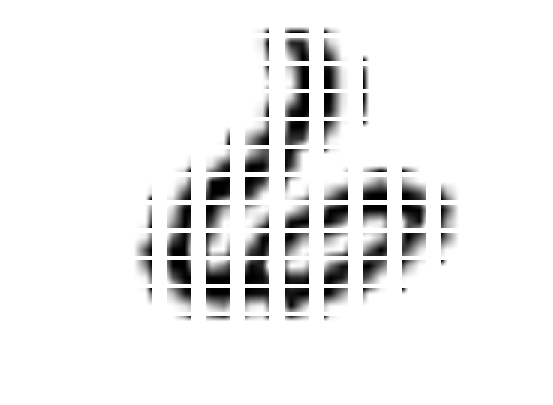

In [77]:
plt.figure(figsize=(7,5))

for i in range(196):
    
    plt.subplot(14,14, i+1)
    

    plt.imshow(b[4][i].view(16,16), cmap = 'binary')
    plt.axis('off')

In [78]:
class LinearProj(nn.Module):
    
    def __init__(self, patch_size, dim):
        super().__init__()
        self.proj = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_size**2),
            nn.Linear(patch_size**2, dim),
            nn.LayerNorm(dim),
        )
        
    def forward(self, x):
        
        return self.proj(x)

class Head(nn.Module):
    
    def __init__(self, emd_size, head_size, dropout = 0.1):
        super().__init__()
        self.query = nn.Linear(emd_size, head_size, bias=False)
        self.key = nn.Linear(emd_size, head_size, bias=False)
        self.value = nn.Linear(emd_size, head_size, bias=False)
        self.head_size = head_size
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, T, C = x.shape
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        
        qk = (q @ k.transpose(-2,-1)) / self.head_size**0.5
#         qk = qk.masked_fill(torch.tril(torch.ones(T, T)) == 0, float('-inf')) # (B, T, T)
        qks = F.softmax(qk, dim=-1) # (B, T, T)
        qks = self.dropout(qks)
        att = qks @ v
        
        return att
        
class MultiHeadAttention(nn.Module):

    def __init__(self, n_heads, emd_size, head_size, dropout = 0.1):
        super().__init__()
        assert head_size % n_heads == 0
        self.head_size = head_size // n_heads
        self.proj = nn.Linear(head_size, emd_size)

        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            Head(emd_size ,self.head_size) for _ in range(n_heads)
        ])

    def forward(self, x):

        x = torch.cat(
            [
                h(x) for h in self.blocks
            ], dim = -1
        )

        x = self.dropout(self.proj(x))

        return x

# class FeedForward(nn.Module):
    
#     def __init__(self, emd_size, hidden_dim, dropout = 0.1):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(emd_size, 4 * emd_size),
#             nn.ReLU(),
#             nn.Linear(4 * emd_size, emd_size),
#             nn.Dropout(dropout),
#         )

#     def forward(self, x):
#         return self.net(x)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)
    
class MLPHead(nn.Module):
    
    def __init__(self, dim, hidden_size, num_classes):
        
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        
        return self.mlp(x)
    
class Block(nn.Module):
    
    def __init__(self, dim, head_size, n_heads, hidden_size):
        super().__init__()
        self.sa = MultiHeadAttention(n_heads, dim, head_size)
        self.ffn = FeedForward(dim, hidden_size)
        self.ln1 = nn.LayerNorm(dim)
        self.ln2 = nn.LayerNorm(dim)
    
    def forward(self, x):
        
#         x = x + self.ln1(self.sa(x))
#         x = x + self.ln2(self.ffn(x))
        x = x + self.sa(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        # Norm then mha then add, 
        return x
    
class ViT(nn.Module):
    
    def __init__(self, patch_size, emd_size , head_size, hidden_size, n_classes, n_heads, n_blocks):
        super().__init__()
        
        self.proj = LinearProj(patch_size, dim)
        self.cls = nn.Parameter(torch.randn(1,1,dim))
        
        self.to_cls_token = nn.Identity()
        self.pos = nn.Parameter(torch.randn(1, 14**2 + 1, dim))
        self.blocks = nn.Sequential(
            *[Block(dim, head_size, n_heads, hidden_size) for _ in range(n_blocks)]
        )
        self.mlp = MLPHead(dim, hidden_size, n_classes)
        
    def forward(self, x):
        
        x = self.proj(x)
        cls_token = self.cls.expand(x.shape[0], -1, -1)
        x = torch.cat([cls_token, x], dim = 1) + self.pos
        x = self.blocks(x)
        x = self.to_cls_token(x[:,0])
        x = self.mlp(x)
        return x
        
        
        
        
        

In [79]:
patch_size = 16
dim = 512
lp = LinearProj(patch_size = patch_size,dim = dim)
img_lp = lp(img)
img_lp.shape

torch.Size([256, 196, 512])

In [80]:
h = Head(emd_size=dim, head_size=300)
img_h = h(img_lp)

In [81]:
mha = MultiHeadAttention(n_heads=10, emd_size=dim, head_size=300)
mha(img_lp).shape

torch.Size([256, 196, 512])

In [82]:
head_size = 10
n_heads = 2
hidden_size = 10
num_classes = 10
dim = 512
n_blocks = 1
bl = Block(dim , head_size, n_heads, hidden_size)
img_bl = bl(img_lp)
img_bl.shape

torch.Size([256, 196, 512])

In [83]:

mlp = MLPHead(dim, hidden_size, num_classes)
mlp(img_bl).shape

torch.Size([256, 196, 10])

In [84]:
img_h.shape

torch.Size([256, 196, 300])

In [85]:
img_lp.shape

torch.Size([256, 196, 512])

In [86]:
a = torch.randn(1,1, dim)
a.shape

torch.Size([1, 1, 512])

In [87]:
a = a.expand(img_lp.shape[0], -1,-1)
a.shape

torch.Size([256, 1, 512])

In [88]:
a = torch.cat([a,img_lp], dim = 1)
a.shape

torch.Size([256, 197, 512])

In [89]:
bl(a).shape

torch.Size([256, 197, 512])

In [90]:
def accuracy(model, loader, criterion, device):
    model.eval()
    n_correct = 0
    loss_total = 0
    for img, labels in loader:
        
        img = img.to(device)
        labels = labels.to(device)
        outputs = model(img)
        
        loss = criterion(outputs, labels)
        
        loss_total += loss.item()
        with torch.no_grad():
          _, classes = torch.max(outputs,1)
          n_correct += ((classes == labels).sum()/outputs.size(0)).item()
            
    return n_correct/len(loader), loss_total/(len(loader))
        
        
        

In [116]:
def epoch_train(model, criterion, optim, loader, device):
    
    model.train()
    n_correct = 0
    loss_total = 0
    
    for img, labels in tqdm(loader):
        
        img = img.to(device)
        labels = labels.to(device)
        outputs = model(img)
        
        loss = criterion(outputs, labels)
#         loss = F.log_softmax(output, labels)
        loss_total+=loss.item()
    
        with torch.no_grad():
          _, classes = torch.max(outputs,1)
          n_correct += ((classes == labels).sum()/outputs.size(0)).item()
            
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    return n_correct/len(loader), loss_total/(len(loader))

def epoch_test(model, loader, criterion, device):
    
    model.eval()
    n_correct = 0
    loss_total = 0
    for img, labels in loader:
        img = img.to(device)
        labels = labels.to(device)
        outputs = model(img)
        
        loss = criterion(outputs, labels)
        
        loss_total += loss.item()
        with torch.no_grad():
          _, classes = torch.max(outputs,1)
          n_correct += ((classes == labels).sum()/outputs.size(0)).item()
            
    return n_correct/len(loader), loss_total/(len(loader))

def train(model, criterion, optim, train_loader, test_loader, epochs, device):
    
    acc_train_list, loss_train_list = [], []
    acc_test_list, loss_test_list = [], []
    
    for epoch in tqdm(range(epochs)):
        
        
        acc_train, loss_train = epoch_train(model, criterion, optim, train_loader, device)
        acc_test, loss_test = epoch_test(model, test_loader,criterion, device)
        
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        
        loss_train_list.append(loss_train)
        loss_test_list.append(loss_test)
        
        
        print(f'Epoch {epoch+1}/{epochs}: Acc_train - {acc_train:.3f}, Loss_train - {loss_train:.3f}'+\
             f' Acc_test - {acc_test:.3f}, Loss_test - {loss_test:.3f}')
    return acc_train_list, loss_train_list, acc_test_list, loss_test_list

In [157]:
head_size = 20
n_heads = 2
hidden_size = 64
num_classes = 10
dim = 512
n_blocks = 1
patch_size = 16

device = 'mps'
vit = ViT(patch_size, dim, head_size, hidden_size, num_classes, n_heads, n_blocks=n_blocks).to(device)
lr = 1e-3
n_epochs = 10
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(vit.parameters(), lr = lr)

In [141]:
acc_train_list, loss_train_list, acc_test_list, loss_test_list = train(vit, criterion, 
                                                          optim, 
                                                          train_loader = train_loader, 
                                                          test_loader = test_loader, 
                                                          epochs=4, 
                                                          device = device)

  0%|                                                     | 0/4 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [108]:
print(f'Test - {accuracy(vit, test_loader, criterion, device)}')
print(f'Train - {accuracy(vit, train_loader, criterion, device)}')

Test - (0.89365234375, 0.3318121187388897)
Train - (0.8870179521276595, 0.3505264727993214)


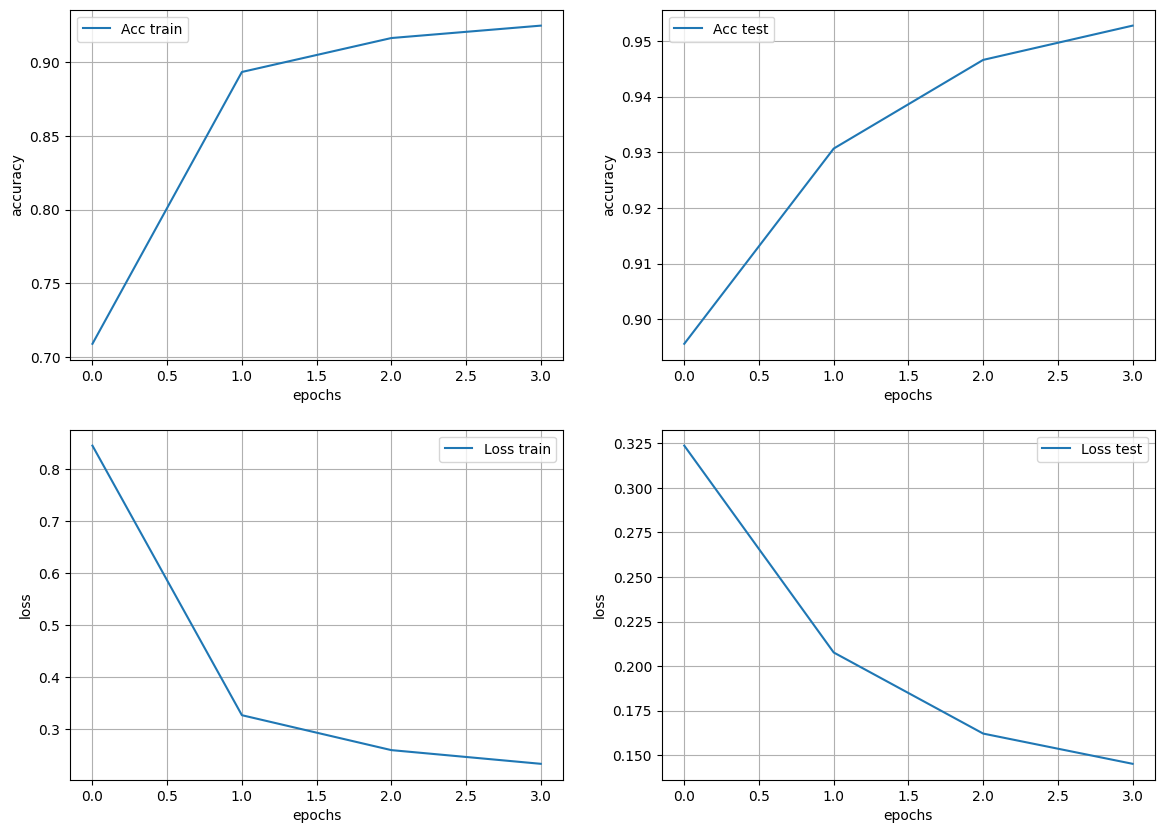

In [134]:
plt.figure(figsize = (14,10))

plt.subplot(2,2,1)
plt.grid()
plt.plot(acc_train_list, label = 'Acc train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.plot(acc_test_list, label = 'Acc test')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(2,2,3)
plt.plot(loss_train_list, label = 'Loss train')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(2,2,4)
plt.plot(loss_test_list, label = 'Loss test')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.savefig('graphs.png')
plt.show()

In [130]:
torch.save(vit.state_dict(), 'vit.pt')

In [204]:
# patch_size, emd_size , head_size, hidden_size, n_classes, n_heads, n_blocks
vit_params = {
    'head_size' : head_size,
    'n_heads' : n_heads,
    'hidden_size' : hidden_size,
    'n_classes' : num_classes,
    'emd_size' : dim,
    'n_blocks' : n_blocks,
    'patch_size': patch_size
}

torch.save(vit_params, 'vit_params.pt')

In [230]:
img, tar = next(iter(test_loader))
img = img.to(device)
tar = tar.to(device)

In [231]:
vit.eval()

ViT(
  (proj): LinearProj(
    (proj): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (to_cls_token): Identity()
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (proj): Linear(in_features=20, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (blocks): ModuleList(
          (0-1): 2 x Head(
            (query): Linear(in_features=512, out_features=10, bias=False)
            (key): Linear(in_features=512, out_features=10, bias=False)
            (value): Linear(in_features=512, out_features=10, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ffn): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=512

In [232]:
preds = vit(img)

In [233]:
preds_soft = F.softmax(preds , dim = -1)

In [234]:
_, classes = torch.max(preds_soft, dim = -1)

In [235]:
classes

tensor([7, 5, 9, 6, 5, 1, 4, 8, 0, 5, 9, 9, 4, 6, 3, 6, 1, 3, 2, 6, 3, 6, 3, 7,
        8, 6, 1, 3, 1, 9, 9, 4, 3, 0, 3, 8, 6, 4, 1, 7, 6, 5, 9, 3, 6, 2, 9, 6,
        2, 7, 4, 3, 2, 9, 3, 1, 9, 1, 7, 8, 5, 2, 1, 9, 3, 0, 2, 7, 7, 2, 5, 4,
        2, 2, 0, 7, 2, 2, 7, 1, 8, 5, 2, 3, 0, 3, 0, 7, 2, 3, 0, 1, 3, 4, 0, 8,
        9, 8, 5, 6, 7, 9, 7, 4, 2, 4, 8, 0, 9, 8, 4, 8, 8, 1, 6, 2, 2, 2, 5, 1,
        4, 1, 0, 4, 0, 2, 3, 0, 7, 8, 1, 6, 6, 6, 6, 4, 7, 1, 1, 1, 3, 8, 1, 8,
        1, 0, 8, 4, 2, 2, 6, 1, 2, 8, 0, 6, 2, 0, 1, 4, 2, 9, 6, 4, 8, 4, 3, 4,
        0, 2, 9, 2, 9, 3, 4, 4, 3, 1, 8, 1, 9, 5, 4, 1, 1, 2, 7, 2, 3, 7, 3, 6,
        0, 4, 3, 0, 1, 0, 4, 2, 8, 9, 6, 0, 9, 9, 0, 0, 5, 7, 4, 1, 1, 8, 2, 9,
        4, 0, 9, 8, 4, 5, 8, 2, 7, 0, 9, 4, 4, 4, 9, 4, 0, 8, 1, 9, 8, 0, 4, 0,
        8, 8, 4, 0, 3, 3, 5, 3, 6, 6, 9, 2, 2, 1, 0, 6], device='mps:0')

In [236]:
tar

tensor([7, 5, 9, 6, 5, 1, 4, 8, 0, 5, 9, 9, 4, 6, 3, 6, 1, 3, 2, 6, 3, 6, 3, 7,
        8, 6, 1, 3, 1, 9, 9, 4, 3, 0, 3, 8, 6, 4, 9, 7, 6, 5, 9, 3, 6, 2, 9, 6,
        2, 9, 4, 3, 2, 9, 3, 1, 9, 1, 7, 8, 5, 2, 1, 9, 3, 0, 2, 7, 7, 2, 5, 4,
        2, 2, 0, 7, 2, 2, 7, 1, 8, 5, 2, 3, 0, 3, 0, 7, 2, 3, 0, 1, 3, 4, 0, 8,
        9, 8, 5, 6, 7, 9, 7, 4, 2, 4, 8, 0, 9, 8, 9, 8, 8, 1, 6, 2, 2, 2, 5, 1,
        4, 1, 0, 4, 6, 2, 3, 0, 7, 3, 1, 6, 6, 6, 6, 4, 7, 1, 1, 1, 3, 8, 1, 8,
        1, 0, 8, 4, 2, 2, 6, 1, 2, 8, 0, 6, 2, 0, 1, 4, 2, 8, 6, 4, 8, 4, 3, 4,
        0, 2, 9, 2, 9, 3, 4, 4, 3, 1, 8, 1, 9, 8, 4, 1, 1, 2, 7, 2, 3, 2, 3, 6,
        0, 4, 8, 0, 1, 0, 4, 2, 8, 9, 6, 6, 9, 9, 0, 0, 5, 7, 4, 1, 1, 8, 2, 9,
        4, 0, 9, 8, 4, 5, 8, 2, 7, 0, 9, 4, 4, 9, 9, 4, 0, 8, 1, 9, 8, 0, 4, 8,
        8, 8, 4, 0, 3, 3, 9, 3, 6, 6, 0, 2, 2, 1, 0, 6], device='mps:0')

In [237]:
(tar == classes).sum() / len(img)

tensor(0.9453, device='mps:0')

In [229]:
params = torch.load('vit_params.pt')
vit = ViT(**params).to(device)
vit_state = torch.load('vit.pt')
vit.load_state_dict(vit_state)

<All keys matched successfully>